In [7]:
!pip install kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matrikasubedi","key":"a84a0fc56738f34df5e5a05dc85d333a"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 26.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.5MB/s]


In [12]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name,'r') as zip:
 zip.extractall()
 print('Done')

Done


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os
from keras.applications import vgg16
from keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.layers import Input
from keras.applications.densenet import DenseNet201
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from sklearn.model_selection import StratifiedKFold


In [0]:
train_dir = "/content/chest_xray/chest_xray/train"
test_dir =  "/content/chest_xray/chest_xray/test"
X = []
Y = []

#Loop through the training and test folders, as well as the 'NORMAL' and 'PNEUMONIA' subfolders and append all images into array X.  Append the classification (0 or 1) into array Y.

for fileName in os.listdir(train_dir + "/NORMAL"): 
        img = cv2.imread(train_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(224,224))
            X.append(img)
    
for fileName in os.listdir(train_dir + "/PNEUMONIA"): 
        img = cv2.imread(train_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(224,224))
            X.append(img)

for fileName in os.listdir(test_dir + "/NORMAL"): 
        img = cv2.imread(test_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(224,224))
            X.append(img)
    
for fileName in os.listdir(test_dir + "/PNEUMONIA"): 
        img = cv2.imread(test_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(224,224))
            X.append(img)

This is an example of a patient X-ray who does not have pneumonia:


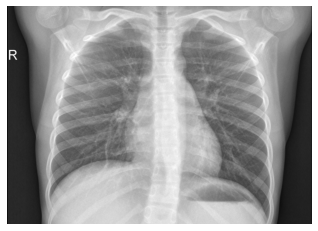

In [8]:
print("This is an example of a patient X-ray who does not have pneumonia:")
normal = cv2.imread(test_dir + "/NORMAL/IM-0003-0001.jpeg")
plt.axis('off')
plt.imshow(normal)

In [0]:
#from keras.utils.np_utils import to_categorical
#Y = to_categorical(Y, num_classes = 2) 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X),Y, test_size=0.2, random_state=42)


In [11]:
Y_train[0]


0

In [0]:
import numpy as np
#from tensorflow.keras.applications import MobileNet,vgg16

In [13]:
model = DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling='avg')
for layer in model.layers:
  layer.trainable = False
inp = model.input
out = model.output

model2 = vgg16.VGG16(include_top=False,weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling='avg')
for layer in model2.layers:
  layer.trainable = False
#Have to make different layer name in keras
for layer in model2.layers:
    layer.name = layer.name + str("_2")

inp2 = model2.input
out2 = model2.output

merged = concatenate([out, out2])
merged = Dense(1024, activation='relu')(merged)
merged = Dense(1,activation='sigmoid')(merged)

model_fusion = Model([inp, inp2], merged)

74842112/74836368 [==============================] - 6s 0us/step


In [0]:
model_fusion.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

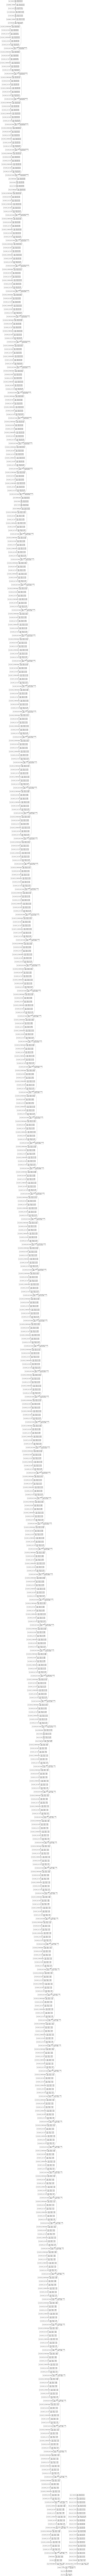

In [18]:
plot_model(model_fusion, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



In [0]:
#history=model_fusion.fit([X_train,X_train], Y_train, batch_size=30, epochs=25, validation_data=([X_test,X_test], Y_test), verbose=1)

In [0]:
batch_size = 50
no_epochs = 25
validation_split = 0.2
verbosity = 1
num_folds = 5

In [0]:
#Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
   # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_fusion.fit([inputs[train],inputs[train]], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              validation_split=validation_split)

  # Generate generalization metrics
  scores = model_fusion.evaluate([inputs[test],inputs[test]], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_fusion.metrics_names[0]} of {scores[0]}; {model_fusion.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1